# `TARexp`: A Python Framework for Technology-Assisted Review Experiments

This is a demo page for `TARexp`. We walk you through the steps for running two major types of experiments currently supperted by `TARexp`. 

## 1. Get Started

If you are running it on Google Colab or have not install `TARexp` in your Python environment yet, please use the following command to install it. 

In [ ]:
!pip3 install tarexp>=0.1.3

And let's get started! Let's first import the essential packages, including `pandas` and classification models from `scikit-learn`. 

In [1]:
import pandas as pd
import tarexp
from tarexp import component
from sklearn.linear_model import LogisticRegression
from ir_measures import *

For this demo, we use vectorized RCV1 provided in `scikit-learn` datasets. 

In [2]:
from sklearn import datasets
rcv1 = datasets.fetch_rcv1()
X = rcv1['data']
rel_info = pd.DataFrame(rcv1['target'].todense().astype(bool), columns=rcv1['target_names'])
ds = tarexp.SparseVectorDataset.from_sparse(X)

## 2. Running TAR Experiments

The following cell defines the experiment. The `settings` variable defines the components the workflow in this experiment is going to use. 

The `exp` variable store the runner of the experiment, which includes the experimenting settings defined in `tarexp.TARExperiment`. If you like to experiment with different components, simply replace this `settings` variable with a list of such settings, `tarexp.TARExperiment` will also conduct experiments with each one of them.
In this specific example, we will be running with `OnePhaseTARWorkflow` with batches of 200. 
We fix the random seed to `123` and run for a maximum 20 TAR rounds. We record R-Precision, Precision at 10, and Optimistic Cost with cost structure (1, 10, 1, 10) and recall target 0.80.
The experiment will iterate through three topics (`GPRO`, `GOBIT`, and `E141`) in RCV1. 

In [3]:
settings = component.combine(component.SklearnRanker(LogisticRegression, solver='liblinear'), 
                              component.PerfectLabeler(), component.RelevanceSampler(), 
                              component.NullStoppingRule())()

exp = tarexp.TARExperiment('./longer_replay', random_seed=123, max_round_exec=20,
                            metrics=[RPrec, P@10, tarexp.OptimisticCost(target_recall=0.8, cost_structure=(1,10,1,10))],
                            tasks=tarexp.TaskFeeder(ds, rel_info[['GPRO', 'GOBIT', 'E141']]),
                            components=settings,
                            workflow=tarexp.OnePhaseTARWorkflow, batch_size=200)


Finally, we start running the experiments. `exp.run` takes in runtime parameters including the number of processes you would like to use. If the experiment results already exists, you will be able to skip them by setting `resume=True`. 

In [4]:
results = exp.run(n_processes=1, resume=True, dump_frequency=10)

Total tasks on node 0:   0%|          | 0/3 [00:00<?, ?it/s]

The experiment results are stored in the `results` variable.  `tarexp.helper.createDFfromResults` provides a helper function for transforming the dictionary into a pandas DataFrame for further analysis. 

In [5]:
tarexp.helper.createDFfromResults(results, remove_redundant_level=True)

target_recall                          0.8               ...     NaN          
section                                all        known  ... unknown          
measure       OptimisticCost(1, 10, 1, 10) Count(False)  ...    P@10     Rprec
dataset round                                            ...                  
E141    0                           774691            0  ...     0.1  1.000000
        1                          7476291          189  ...     1.0  0.833333
        2                          6830931          386  ...     1.0  0.866667
        3                          4101561          584  ...     1.0  0.882353
        4                          1098781          767  ...     1.0  0.705882
...                                    ...          ...  ...     ...       ...
GPRO    17                          428719         1122  ...     1.0  0.935498
        18                          373519         1222  ...     1.0  0.931484
        19                          422289         1330  ...     1.0  0.930797
        20                          424809         1436  ...     1.0  0.928265
        21                          460739         1563  ...     1.0  0.920394

[66 rows x 11 columns]

## 3. Running Stopping Rule Experiments

We also demonstrate an experiment for stopping rules!

The following cell imports more stopping rules implemented in `TARexp`. 

In [6]:
from tarexp.component.stopping import (KneeStoppingRule, BudgetStoppingRule, 
                                      BatchPrecStoppingRule, ReviewHalfStoppingRule,
                                      Rule2399StoppingRule, QuantStoppingRule, 
                                      CHMHeuristicsStoppingRule)

Here we define a stopping rule experiment that directly take advantage on the experiment we just ran above by specifying the replay workflow as `tarexp.OnePhaseTARWorkflowReplay`. 
The `stopping_rules` argument defines a list of stopping rule we would like test on. Different target recall of the same stopping rule class are considered as different rules.
Additionally, we also record the Optimistic Cost for recall target 0.80 and 0.90 during replay by adding them to argument `metrics`. 

In [7]:
replay_exp = tarexp.StoppingExperimentOnReplay(
                    './test_stopping_rules', random_seed=123,
                    tasks=tarexp.TaskFeeder(ds, rel_info[['GPRO','GOBIT', 'E141']]),
                    replay=tarexp.OnePhaseTARWorkflowReplay,
                    saved_exp_path='./longer_replay',
                    metrics=[tarexp.OptimisticCost(target_recall=0.8, cost_structure=(1,1,1,1)),
                             tarexp.OptimisticCost(target_recall=0.9, cost_structure=(1,1,1,1))],
                    stopping_rules=[
                        KneeStoppingRule(), BudgetStoppingRule(), 
                        BatchPrecStoppingRule(), ReviewHalfStoppingRule(),
                        Rule2399StoppingRule(), 
                        QuantStoppingRule(0.4, 0), QuantStoppingRule(0.2, 0),
                        QuantStoppingRule(0.8, 0),
                        CHMHeuristicsStoppingRule(0.8),
                        CHMHeuristicsStoppingRule(0.4),
                        CHMHeuristicsStoppingRule(0.2),
                    ]
            )

stopping_results = replay_exp.run(resume=True, dump_frequency=10)
df = tarexp.helper.createDFfromResults(stopping_results, remove_redundant_level=True)

Total tasks on node 0:   0%|          | 0/3 [00:00<?, ?it/s]

Found saved info for iteration 21.
Found saved info for iteration 21.
Found saved info for iteration 21.


\The results are also stored in `results` variable.
Alternatively, you can also load an existing experiment from the disk by providing the path like the following cell. 

In [ ]:
df = tarexp.helper.createDFfromResults('./test_stopping_rules', remove_redundant_level=True, disable_tqdm=True)

The following is an example of the replay run on topic `GPRO`. The stopping decisions of each rule at each round are recorded in the DataFrame. The cost information are also recorded for recall target 0.80 and 0.90 as those are the two we specified in the experiment. 

In [11]:
df.loc[:, 'GPRO', :]

target_recall                                                                                            0.2  ...                                      NaN
section                                                                                                  all  ...                                      all
measure                                             CHMHeuristicsStoppingRule[alpha=0.05, target_recall=0.2]  ... Rule2399StoppingRule[target_recall=None]
save_path                             dataset round                                                           ...                                         
GPRO.61b1f31a0a29de634939db77c0dde383 GPRO    0                                                  False        ...                                    False
                                              1                                                  False        ...                                    False
                                              2                                                  False        ...                                    False
                                              3                                                  False        ...                                    False
                                              4                                                  False        ...                                    False
                                              5                                                  False        ...                                    False
                                              6                                                  False        ...                                    False
                                              7                                                  False        ...                                    False
                                              8                                                  False        ...                                    False
                                              9                                                  False        ...                                    False
                                              10                                                 False        ...                                    False
                                              11                                                 False        ...                                    False
                                              12                                                 False        ...                                    False
                                              13                                                 False        ...                                    False
                                              14                                                 False        ...                                    False
                                              15                                                 False        ...                                    False
                                              16                                                 False        ...                                    False
                                              17                                                 False        ...                                    False
                                              18                                                 False        ...                                    False
                                              19                                                 False        ...                                    False
                                              20                                                 False        ...                                    False
                                              21                                                 False        ...            

Finally, we can create the cost dynamic graph with the `tarexp.helper.cost_dynamic` helper function. It returns a `matplotlib.Figure`. For user that are familiar with `matplotlib`, you are able to further manipulate the graph. Here, we just set the dpi to 150 by using `.set_dpi()` as an demonstration. 

The following cell creates plots for each cost structure. 

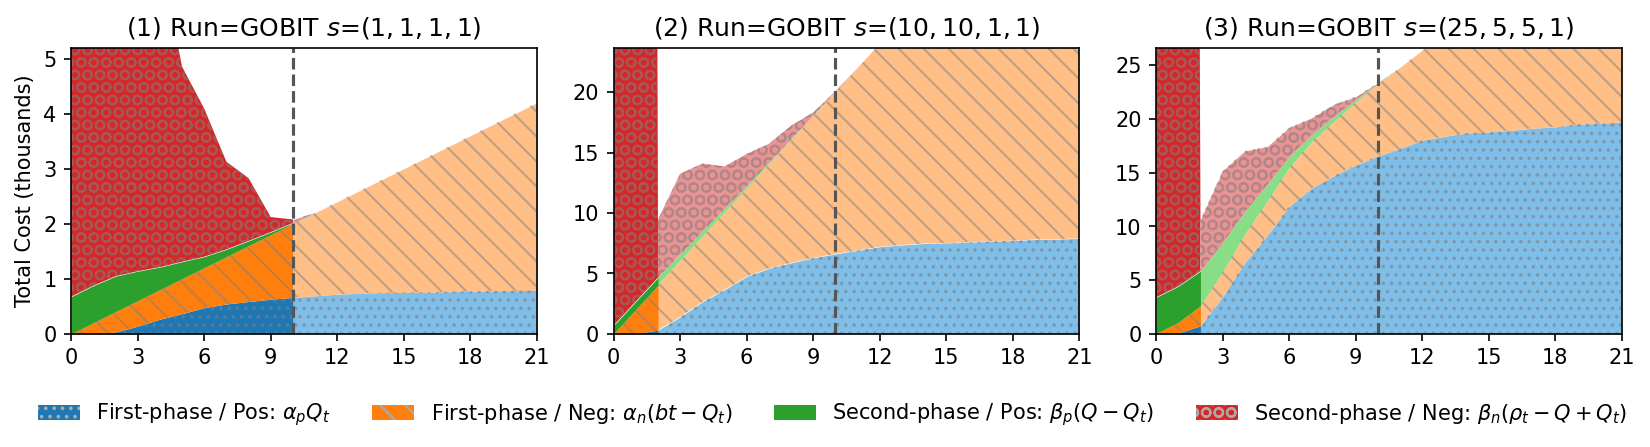

In [12]:
tarexp.helper.cost_dynamic(
    df.loc[:, 'GOBIT', :].groupby(level='dataset'),
    recall_targets=[0.8], cost_structures=[(1,1,1,1), (10, 10, 1, 1), (25, 5, 5, 1)],
    with_hatches=True
).set_dpi(150)

Alternatively, you can also create graphs with multiple datasets like the following. 

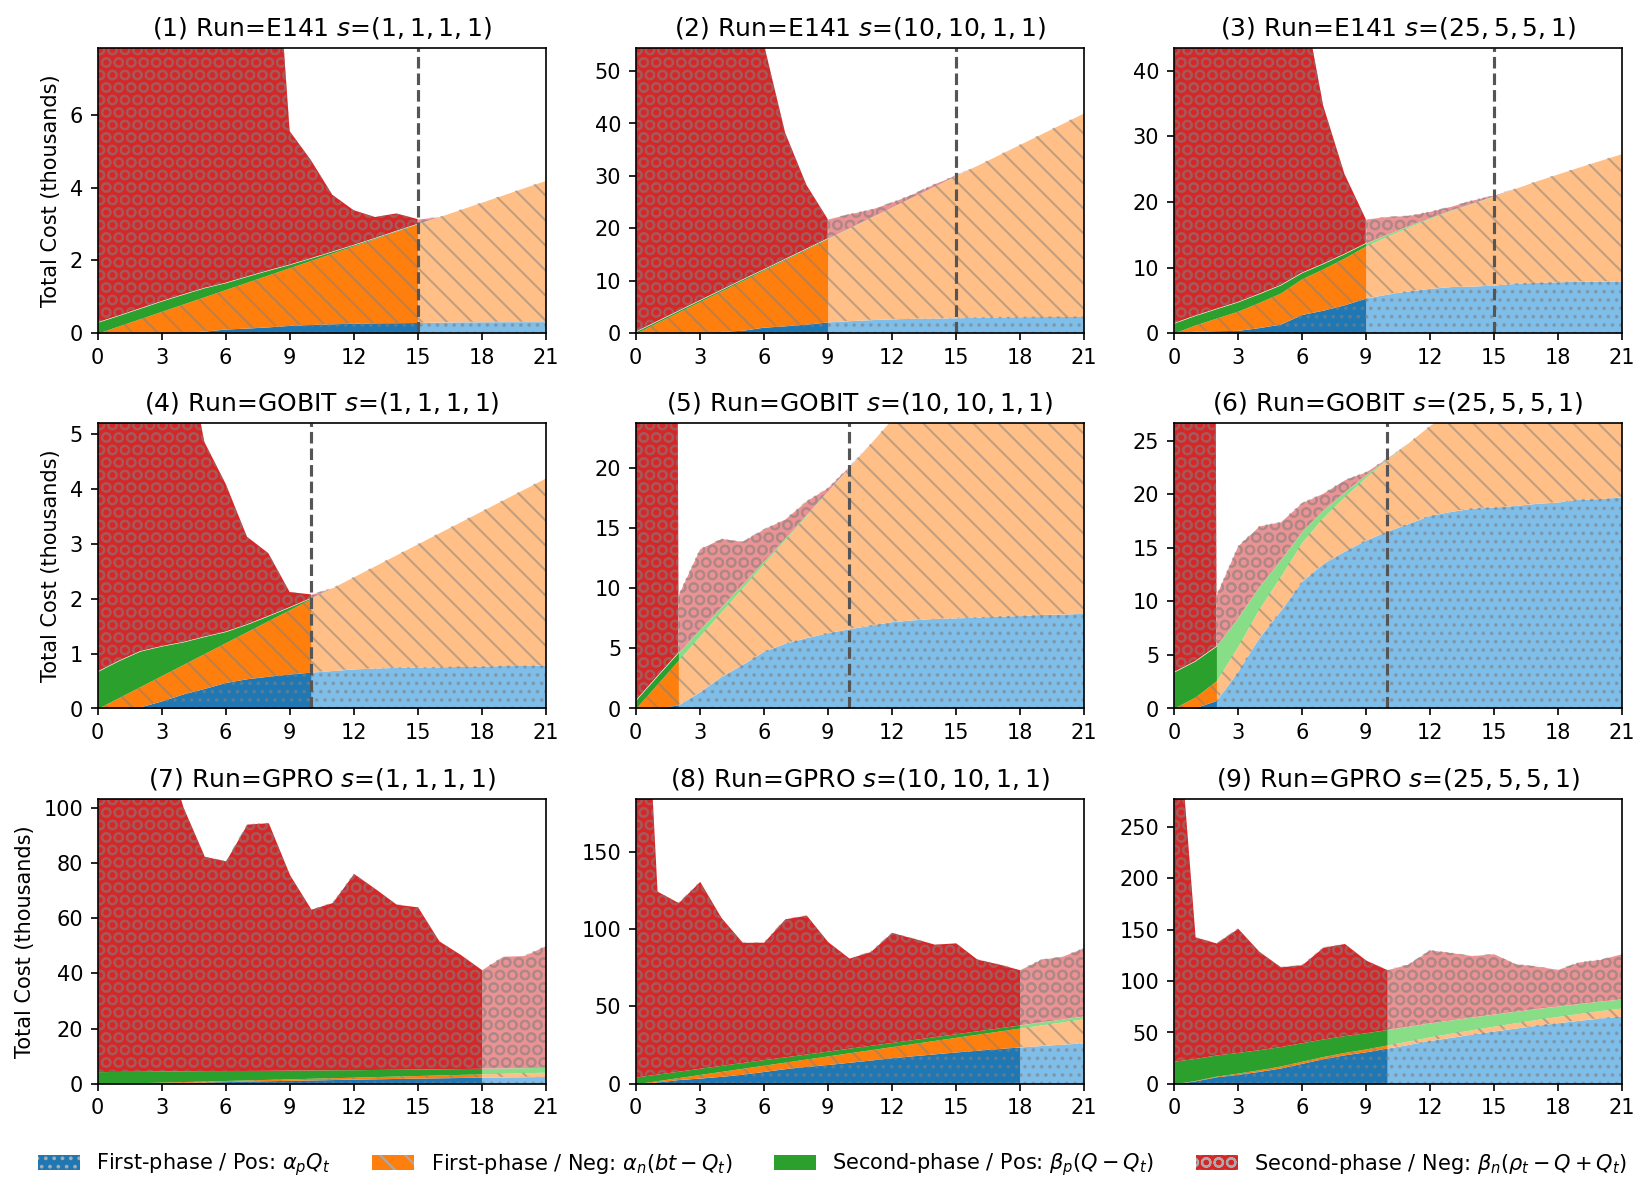

In [15]:
tarexp.helper.cost_dynamic(
    df.groupby(level='dataset'),
    recall_targets=[0.8], cost_structures=[(1,1,1,1), (10, 10, 1, 1), (25, 5, 5, 1)],
    with_hatches=True
).set_dpi(150)

## Thoughts and Feedback? 

Any feedback is welcomed! Feel free to email the author [eugene.yang@jhu.edu](eugene.yang@jhu.edu) or raise an issue in our [GiHub](https://github.com/eugene-yang/tarexp)!